In [67]:
# Data preprocessing, math and plotting
import os
import numpy as np 
import pandas as pd 
from scipy import stats 
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
import time
import random
import warnings
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')

# ML
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, auc, classification_report, r2_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score  
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.utils import resample

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\trevor.sauerbrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# HYPERPARAMETERS
RANDOM_STATE = 12
TRAIN_SPLIT = 0.80
OOV_TOK = "<OOV>"
VOCAB_SIZE = 10000
MAX_LENGTH = 120
MAX_ITER = 10000
N_JOBS = 4
N_NEIGHBORS = 5
N_ESTIMATORS = 50
MAX_DEPTH = 1

In [13]:
data = pd.read_csv(r'olist_order_reviews_dataset.csv')
data.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [14]:
# columns_to_keep = ['review_score', 'review_comment_message']
# data_drop = data.drop(columns=[col for col in data.columns if col not in columns_to_keep])
# data_drop

# data_drop_nans = data_drop.dropna(subset=['review_comment_message'])
# nan_counts = data_drop_nans.isnull().sum()
# print(nan_counts)
# data_drop_nans

In [15]:
def clean_data(data, column_text='review_comment_message', 
               column_score='review_score', 
               points_cut = [0, 2, 5], 
               classes = [0, 1]):
    
    df_bin = data
    df_bin = df_bin.dropna(subset=[column_text])
    df_bin['label'] = pd.cut(df_bin[column_score], bins=points_cut, labels=classes)
    df_bin = df_bin.rename(columns={column_text: 'text'})
    df_bin = df_bin[['text','label']]
    
    df_cat = data
    df_cat = df_cat.dropna(subset=[column_text])
    df_cat = df_cat.rename(columns={column_text: 'text' , column_score: 'label'})
    df_cat = df_cat[['text','label']]
    return df_bin ,df_cat

data_bin , data_cat = clean_data(data)

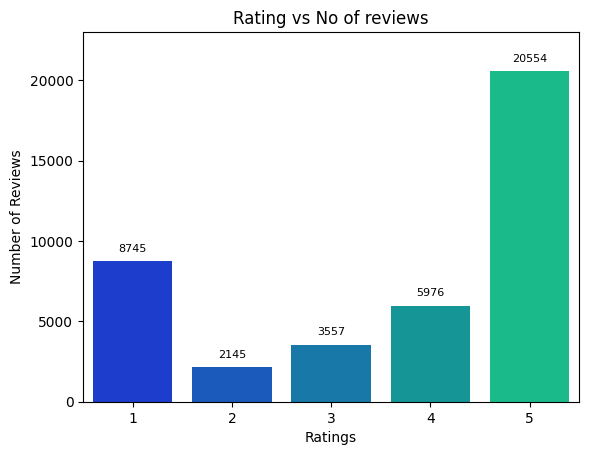

In [16]:
ax = sns.countplot(x=data_cat['label'], palette='winter')
plt.xlabel('Ratings')
plt.ylabel('Number of Reviews')
plt.title('Rating vs No of reviews')

# Add count labels to each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize=8)
ax.set_ylim(0, 23000)  

plt.show()

# WORDCLOUD

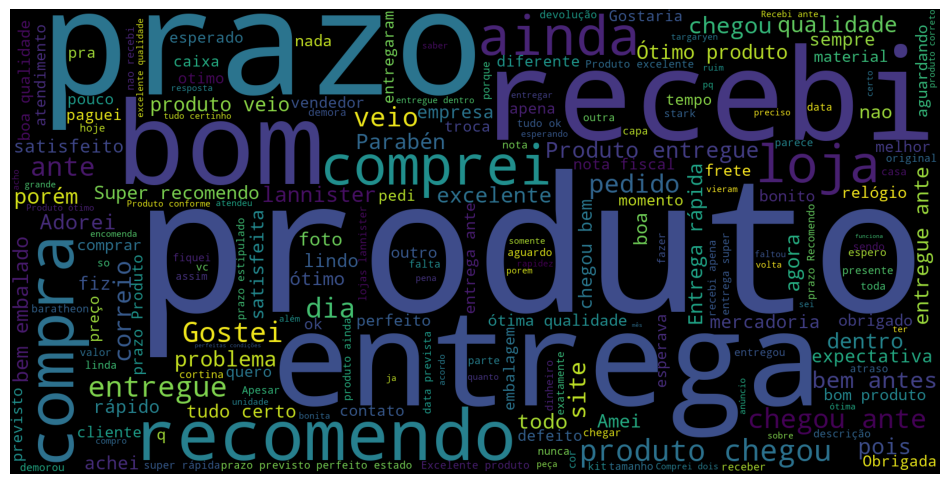

In [17]:
stop_words = stopwords.words('portuguese')
wordcloud = WordCloud(stopwords=stop_words,
                      background_color="black",
                      width=1600, height=800).generate(' '.join(data_bin["text"]))

fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud);

In [18]:
def split_test_train(data, split_train=TRAIN_SPLIT, random_state=RANDOM_STATE):
    # Separate majority and minority classes
    df_majority = data[data['label']==0]
    df_minority = data[data['label']==1]

    # Undersample majority class
    n_samples = min(len(df_majority), len(df_minority))
    df_majority_downsampled = resample(df_majority, 
                                       replace=False,    # sample without replacement
                                       n_samples=n_samples, # match minority class
                                       random_state=random_state)

    # Combine minority class with downsampled majority class
    df_balanced = pd.concat([df_majority_downsampled, df_minority])

    # Split into train and test sets
    df_train = df_balanced.sample(frac=split_train, random_state=random_state)
    df_test = df_balanced.drop(df_train.index)
    X_train = df_train['text'].tolist()
    y_train = df_train['label'].values
    X_test = df_test['text'].tolist()
    y_test = df_test['label'].values

    return X_train , y_train , X_test , y_test

X_train , y_train , X_test , y_test = split_test_train(data_bin, split_train=TRAIN_SPLIT, random_state=RANDOM_STATE)

In [19]:
# Import the Tokenizer class from the keras.preprocessing.text module and instantiate an object with specified parameters.
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token=OOV_TOK)

# Fit the tokenizer on the training set, creating a word index based on the frequency of occurrence of each word in the corpus.
tokenizer.fit_on_texts(X_train)

# Define a function to preprocess the text data by converting each sentence into a sequence of integers using the fitted tokenizer and padding/truncating them to a fixed length.
def preprocess(X_train, X_test, max_length, vocab_size, trunc_type='post', oov_tok = "<OOV>"):

    # Convert each sentence in the training set to a sequence of integers using the fitted tokenizer.
    training_sequences = tokenizer.texts_to_sequences(X_train)

    # Pad the sequences to a fixed length by adding zeros or truncating from the beginning or end based on the trunc_type parameter.
    X_train_padded = pad_sequences(training_sequences,maxlen=max_length, truncating=trunc_type)

    # Convert each sentence in the test set to a sequence of integers using the fitted tokenizer.
    testing_sequences = tokenizer.texts_to_sequences(X_test)

    # Pad the sequences to a fixed length without truncation since the test set should not be modified.
    X_test_padded = pad_sequences(testing_sequences,maxlen=max_length)

    # Return the padded training and test sets as output of the function.
    return X_train_padded, X_test_padded

# Call the preprocess function on the training and test sets to obtain padded and processed data.
X_train, X_test = preprocess(X_train, X_test, MAX_LENGTH, VOCAB_SIZE)

In [20]:
%%time
nb = MultinomialNB()
nb.fit(X_train,y_train)
nb_preds = nb.predict(X_test)
print("Model score on Training Data = ", nb.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", nb.score(X_test,y_test)*100 ,"%")

Model score on Training Data =  74.48904886828137 %
Model score on Testing Data =  74.37461866992068 %
CPU times: total: 125 ms
Wall time: 103 ms


In [21]:
%%time
lr = LogisticRegression(max_iter= MAX_ITER,random_state=RANDOM_STATE, n_jobs= N_JOBS)
lr.fit(X_train,y_train)
lr_preds = lr.predict(X_test)
print("Model score on Training Data = ", lr.score(X_train,y_train)*100,"%")
print("Model score on Testing Data = ", lr.score(X_test,y_test)*100,"%")

Model score on Training Data =  74.37008114209017 %
Model score on Testing Data =  73.88651616839536 %
CPU times: total: 234 ms
Wall time: 39.4 s


In [37]:
%%time
svm = SVC(random_state=RANDOM_STATE , verbose = True, probability=True)
svm.fit(X_train,y_train)
sv_preds = svm.predict(X_test)
print("Model score on Training Data = ", svm.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", svm.score(X_test,y_test)*100 ,"%")

[LibSVM]Model score on Training Data =  79.81209200170825 %
Model score on Testing Data =  74.7895057962172 %
CPU times: total: 26min 47s
Wall time: 27min 38s


In [23]:
%%time
rfc = RandomForestClassifier(n_estimators = 100, random_state =RANDOM_STATE , n_jobs = N_JOBS)
rfc.fit(X_train,y_train)
rf_preds = rfc.predict(X_test)
print("Model score on Training Data = ", rfc.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", rfc.score(X_test,y_test)*100 ,"%")

Model score on Training Data =  99.61259227624916 %
Model score on Testing Data =  78.40146430750458 %
CPU times: total: 22.6 s
Wall time: 6.01 s


In [24]:
%%time
xgb = XGBClassifier(objective='binary:logistic' , 
                    use_label_encoder=False,  
                    random_state = RANDOM_STATE,
                    eval_metric='mlogloss')
xgb.fit(X_train,y_train)
xg_preds = xgb.predict(X_test)
print("Model score on Training Data = ", xgb.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", xgb.score(X_test,y_test)*100 ,"%")

Model score on Training Data =  93.12732597156976 %
Model score on Testing Data =  82.74557657107992 %
CPU times: total: 43.6 s
Wall time: 5.96 s


In [25]:
%%time
ada_clf = AdaBoostClassifier(random_state=RANDOM_STATE)
ada_clf.fit(X_train, y_train)
ada_preds = ada_clf.predict(X_test)
print("Model score on Training Data = ", ada_clf.score(X_train, y_train)*100 ,"%")
print("Model score on Testing Data = ", ada_clf.score(X_test, y_test)*100 ,"%")

Model score on Training Data =  76.70977975718381 %
Model score on Testing Data =  76.32702867602197 %
CPU times: total: 10.1 s
Wall time: 10.2 s


In [26]:
%%time
knn = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)
print("Model score on Training Data = ", knn.score(X_train, y_train) * 100, "%")
print("Model score on Testing Data = ", knn.score(X_test, y_test) * 100, "%")

Model score on Training Data =  81.03837471783297 %
Model score on Testing Data =  73.80109823062844 %
CPU times: total: 1min 39s
Wall time: 57.6 s


In [27]:
%%time
mlp = MLPClassifier(random_state=RANDOM_STATE, verbose=True)
mlp.fit(X_train, y_train)
mlp_preds = mlp.predict(X_test)
print("Model score on Training Data = ", mlp.score(X_train, y_train) * 100, "%")
print("Model score on Testing Data = ", mlp.score(X_test, y_test) * 100, "%")

Iteration 1, loss = 6.35450988
Iteration 2, loss = 4.70976297
Iteration 3, loss = 4.04980171
Iteration 4, loss = 3.71172296
Iteration 5, loss = 3.45514328
Iteration 6, loss = 3.12418266
Iteration 7, loss = 2.99725397
Iteration 8, loss = 2.64632230
Iteration 9, loss = 2.56305969
Iteration 10, loss = 2.45601718
Iteration 11, loss = 2.24092394
Iteration 12, loss = 2.15921561
Iteration 13, loss = 2.01321692
Iteration 14, loss = 1.95306214
Iteration 15, loss = 1.80675476
Iteration 16, loss = 1.87259744
Iteration 17, loss = 1.61026269
Iteration 18, loss = 1.61598755
Iteration 19, loss = 1.49666641
Iteration 20, loss = 1.45196592
Iteration 21, loss = 1.34594402
Iteration 22, loss = 1.24930591
Iteration 23, loss = 1.26213708
Iteration 24, loss = 1.17723369
Iteration 25, loss = 1.12755402
Iteration 26, loss = 1.11650849
Iteration 27, loss = 1.01948330
Iteration 28, loss = 1.03973633
Iteration 29, loss = 1.01372426
Iteration 30, loss = 0.92269893
Iteration 31, loss = 0.88880641
Iteration 32, los

In [34]:
%%time
sgd = SGDClassifier(random_state=RANDOM_STATE, verbose=True)
sgd.fit(X_train, y_train)
sgd_preds = sgd.predict(X_test)
print("Model score on Training Data = ", sgd.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", sgd.score(X_test,y_test)*100 ,"%")

-- Epoch 1
Norm: 10605.53, NNZs: 44, Bias: 2818.504204, T: 32782, Avg. loss: 4433156.898510
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 4276.25, NNZs: 44, Bias: 3390.354681, T: 65564, Avg. loss: 858089.594799
Total training time: 0.04 seconds.
-- Epoch 3
Norm: 2935.68, NNZs: 44, Bias: 3695.427738, T: 98346, Avg. loss: 491876.197107
Total training time: 0.06 seconds.
-- Epoch 4
Norm: 3038.78, NNZs: 44, Bias: 3888.998969, T: 131128, Avg. loss: 354747.794264
Total training time: 0.07 seconds.
-- Epoch 5
Norm: 2020.81, NNZs: 44, Bias: 4018.810855, T: 163910, Avg. loss: 273570.547458
Total training time: 0.09 seconds.
-- Epoch 6
Norm: 1477.51, NNZs: 44, Bias: 4126.281738, T: 196692, Avg. loss: 222981.444559
Total training time: 0.11 seconds.
-- Epoch 7
Norm: 1544.88, NNZs: 44, Bias: 4217.574560, T: 229474, Avg. loss: 193530.924236
Total training time: 0.13 seconds.
-- Epoch 8
Norm: 1274.20, NNZs: 44, Bias: 4283.668391, T: 262256, Avg. loss: 165128.946515
Total training time: 0.15 se

In [ ]:
nb = MultinomialNB()
nb.fit(X_train,y_train)
nb_preds = nb.predict(X_test)
print("Model score on Training Data = ", nb.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", nb.score(X_test,y_test)*100 ,"%")

lr = LogisticRegression(max_iter= MAX_ITER,random_state=RANDOM_STATE, n_jobs= N_JOBS)
lr.fit(X_train,y_train)
lr_preds = lr.predict(X_test)
print("Model score on Training Data = ", lr.score(X_train,y_train)*100,"%")
print("Model score on Testing Data = ", lr.score(X_test,y_test)*100,"%")

svm = SVC(random_state=RANDOM_STATE , verbose = True, probability=True)
svm.fit(X_train,y_train)
sv_preds = svm.predict(X_test)
print("Model score on Training Data = ", svm.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", svm.score(X_test,y_test)*100 ,"%")

rfc = RandomForestClassifier(n_estimators = 100, random_state =RANDOM_STATE , n_jobs = N_JOBS)
rfc.fit(X_train,y_train)
rf_preds = rfc.predict(X_test)
print("Model score on Training Data = ", rfc.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", rfc.score(X_test,y_test)*100 ,"%")

xgb = XGBClassifier(objective='binary:logistic' , 
                    use_label_encoder=False,  
                    random_state = RANDOM_STATE,
                    eval_metric='mlogloss')
xgb.fit(X_train,y_train)
xg_preds = xgb.predict(X_test)
print("Model score on Training Data = ", xgb.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", xgb.score(X_test,y_test)*100 ,"%")

ada_clf = AdaBoostClassifier(random_state=RANDOM_STATE)
ada_clf.fit(X_train, y_train)
ada_preds = ada_clf.predict(X_test)
print("Model score on Training Data = ", ada_clf.score(X_train, y_train)*100 ,"%")
print("Model score on Testing Data = ", ada_clf.score(X_test, y_test)*100 ,"%")

knn = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)
print("Model score on Training Data = ", knn.score(X_train, y_train) * 100, "%")
print("Model score on Testing Data = ", knn.score(X_test, y_test) * 100, "%")

mlp = MLPClassifier(random_state=RANDOM_STATE, verbose=True)
mlp.fit(X_train, y_train)
mlp_preds = mlp.predict(X_test)
print("Model score on Training Data = ", mlp.score(X_train, y_train) * 100, "%")
print("Model score on Testing Data = ", mlp.score(X_test, y_test) * 100, "%")

sgd = SGDClassifier(random_state=RANDOM_STATE, verbose=True)
sgd.fit(X_train, y_train)
sgd_preds = sgd.predict(X_test)
print("Model score on Training Data = ", sgd.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", sgd.score(X_test,y_test)*100 ,"%")

# Machine learning Models

In [45]:
models = {
    "Stochastic Gradient Descent (SGD)": sgd,
    "Naive Bayes": nb,
    "Support Vector Machine": svm,
    "Logistic Regression": lr,
    "Random Forest Classifier": rfc,
    "XGBoost Classifier": xgb,
    "K-Nearest Neighbors Classifier": knn,
    "Multilayer Perceptron Classifier": mlp,
    "AdaBoost Classifier": ada_clf,
}

# Model Performance Metrics

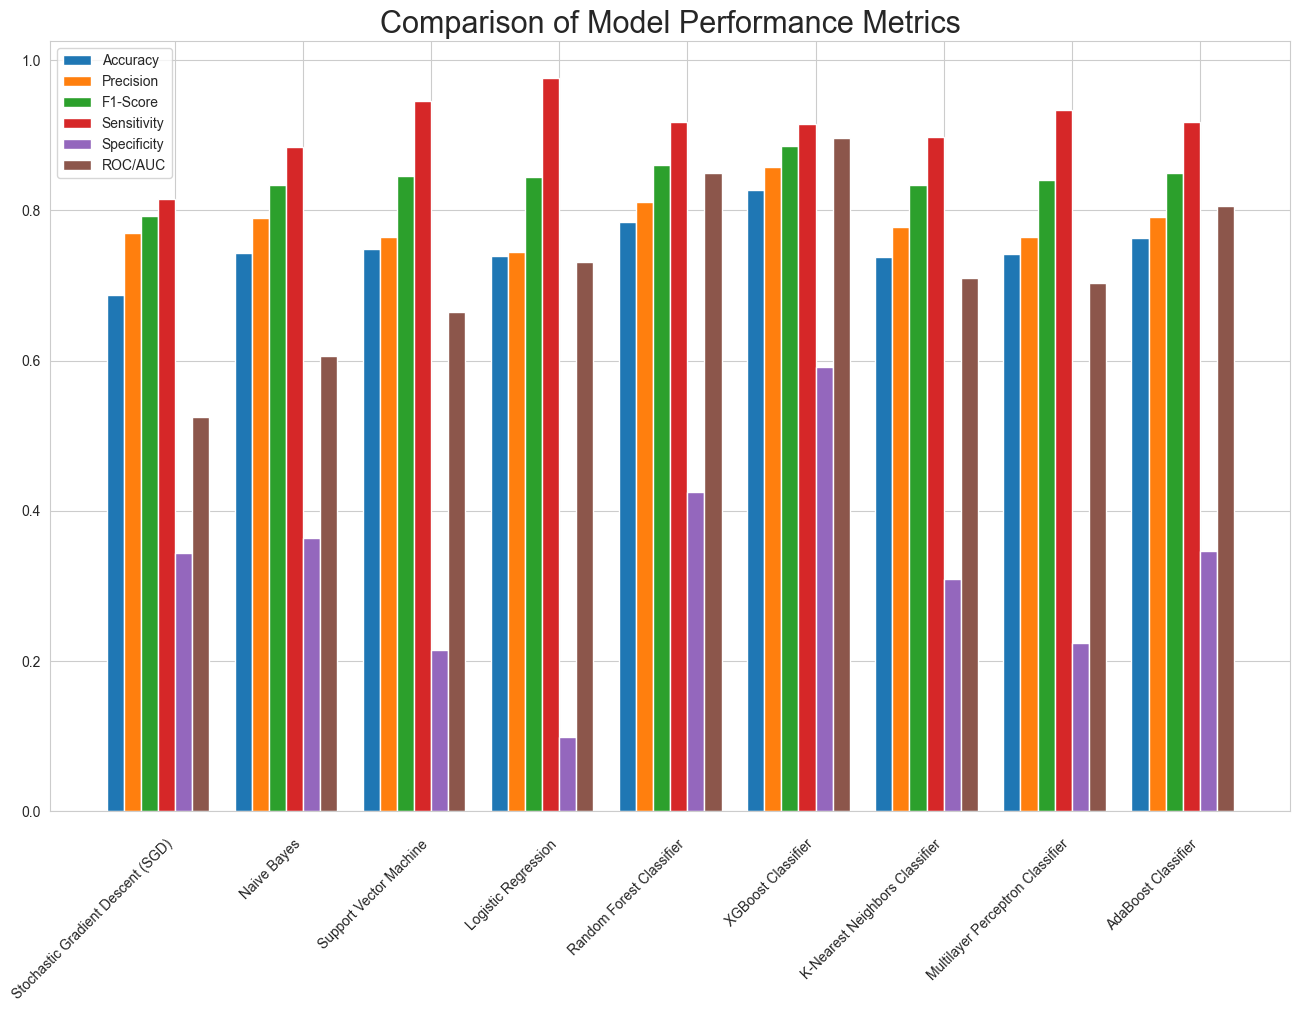

In [69]:
models = {
    "Stochastic Gradient Descent (SGD)": sgd,
    "Naive Bayes": nb,
    "Support Vector Machine": svm,
    "Logistic Regression": lr,
    "Random Forest Classifier": rfc,
    "XGBoost Classifier": xgb,
    "K-Nearest Neighbors Classifier": knn,
    "Multilayer Perceptron Classifier": mlp,
    "AdaBoost Classifier": ada_clf,
}

metrics = {}
for name, model in models.items():
    if name == "Stochastic Gradient Descent (SGD)":
        pred = model.decision_function(X_test)
    else:
        pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    accuracy = accuracy_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    recall = recall_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    metrics[name] = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1,
                     "Sensitivity": sensitivity, "Specificity": specificity, "FPR": fpr, "TPR": tpr, "ROC/AUC": roc_auc}

# Bar chart of performance metrics
metric_names = ["Accuracy", "Precision", "F1-Score", "Sensitivity", "Specificity", "ROC/AUC"]
num_metrics = len(metric_names)
num_models = len(models)

fig, ax = plt.subplots(figsize=(16, 10))
width = 0.8 / num_metrics

for i, metric in enumerate(metric_names):
    offset = (i - num_metrics / 2) * width
    values = [metrics[name][metric] for name in models.keys()]
    ax.bar(np.arange(num_models) + offset, values, width=width, label=metric, align='center')

ax.set_xticks(np.arange(num_models) + width/2)  # Add half of the bar width
ax.set_xticklabels(models.keys(), rotation=45, ha='right')
ax.tick_params(axis='x', which='major', pad=15)
ax.legend()
ax.set_title("Comparison of Model Performance Metrics", fontsize=22)

plt.show()

# Confusion Matrices

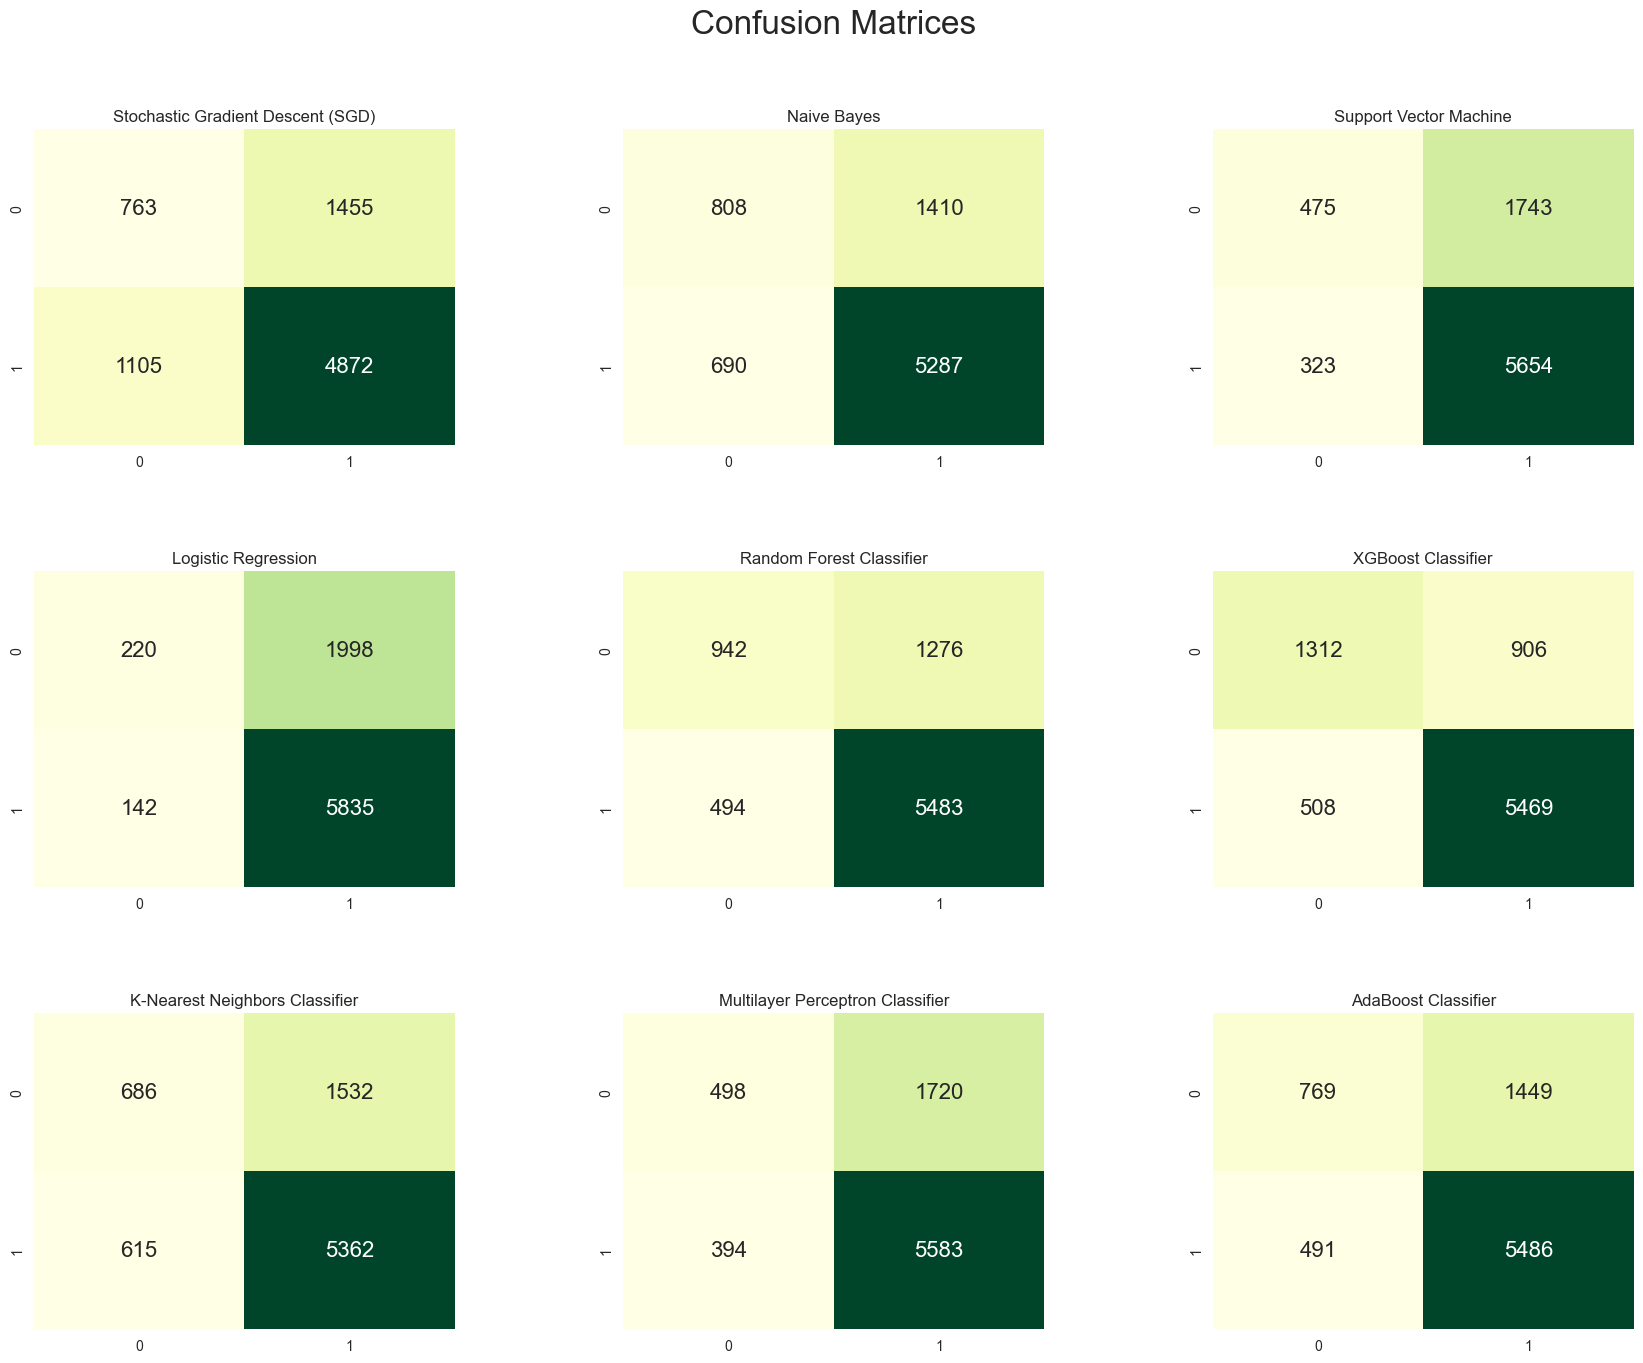

In [56]:
plt.figure(figsize=(20, 15))
plt.suptitle("Confusion Matrices", fontsize=24)

for i, (name, model) in enumerate(models.items()):
    cm = confusion_matrix(y_test, model.predict(X_test))
    plt.subplot(3, 3, i+1)
    plt.title(name)
    sns.heatmap(cm, cbar=False, cmap="YlGn", annot=True, annot_kws={"size": 16}, fmt='g')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

# ROC-AUC Curves Comparison

Text(0.5, 0.98, 'Receiver Operating Characteristic Curves for Different Models')

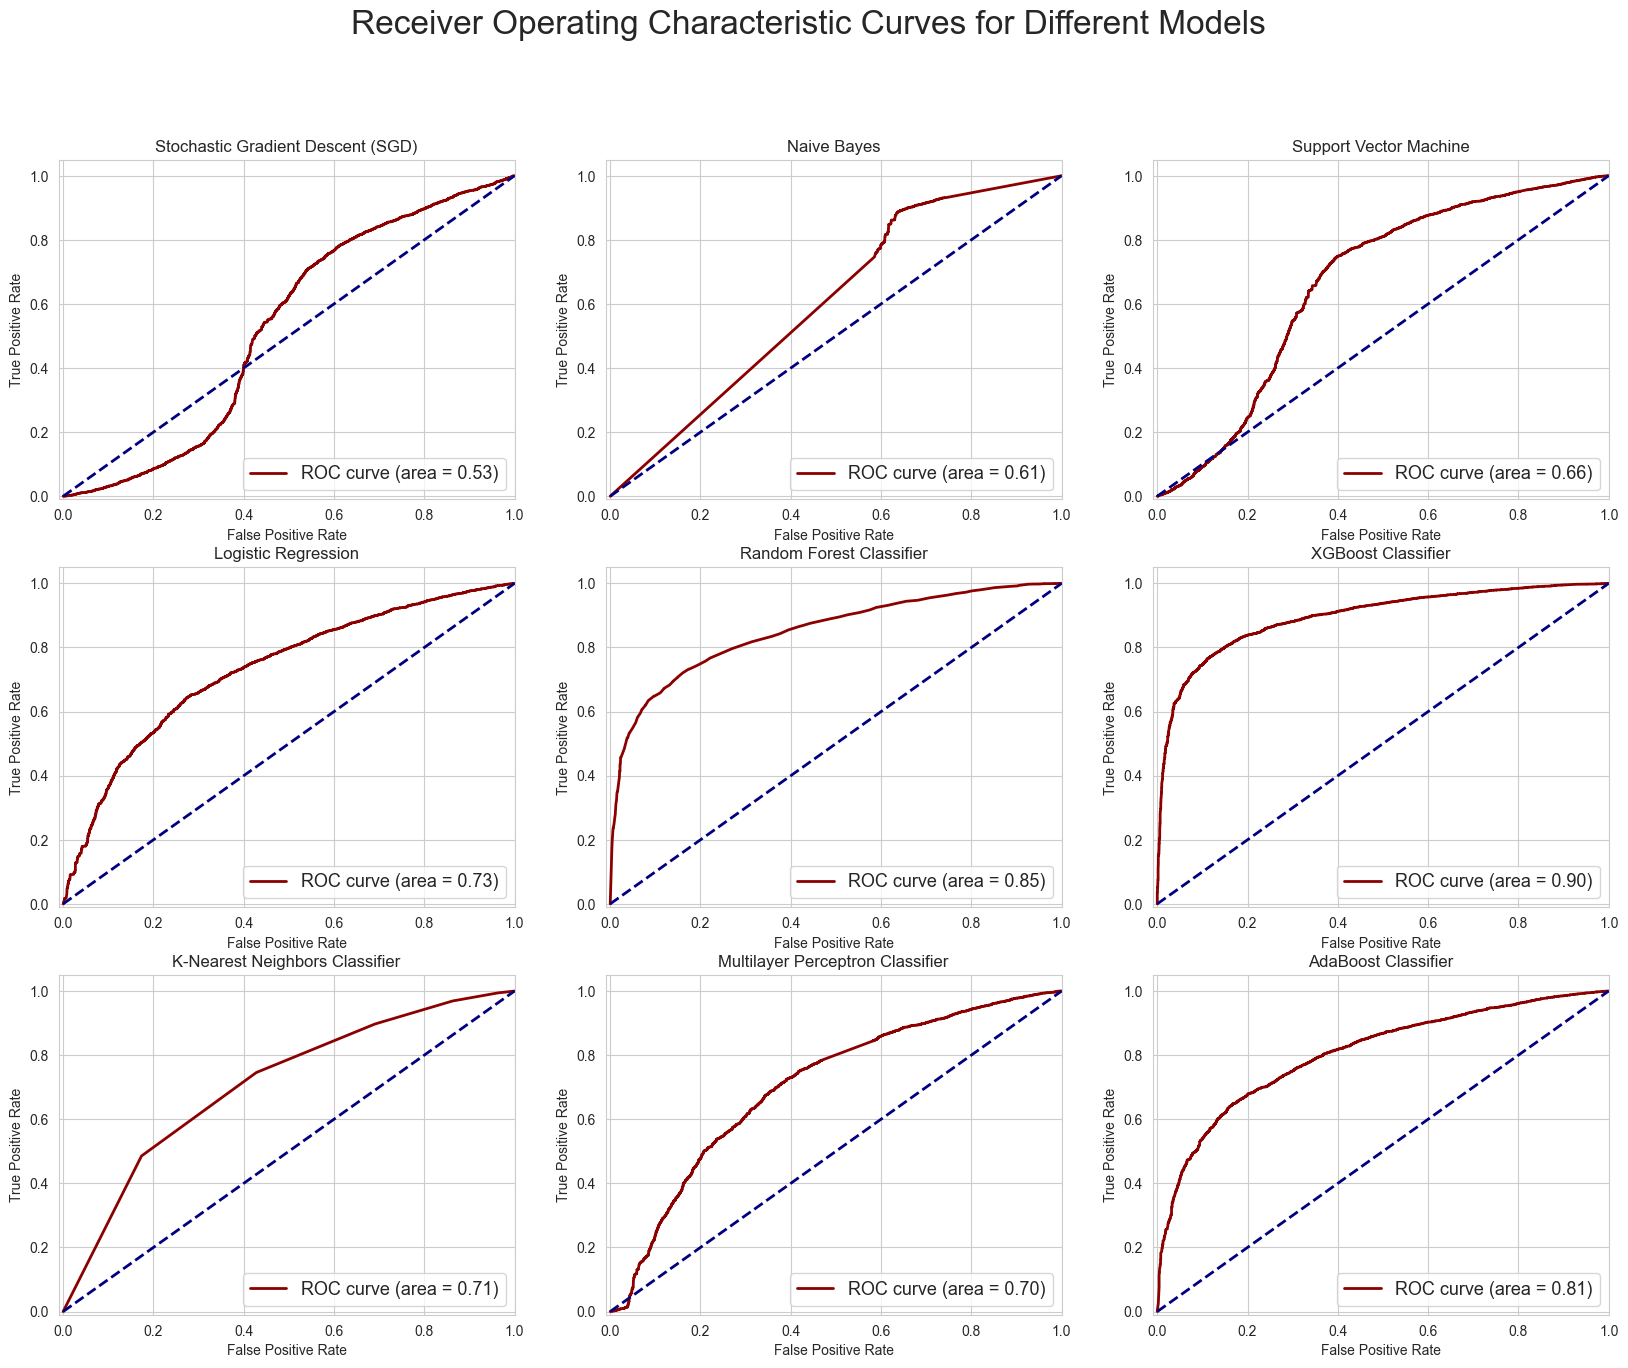

In [60]:
models = {
    "Stochastic Gradient Descent (SGD)": sgd,
    "Naive Bayes": nb,
    "Support Vector Machine": svm,
    "Logistic Regression": lr,
    "Random Forest Classifier": rfc,
    "XGBoost Classifier": xgb,
    "K-Nearest Neighbors Classifier": knn,
    "Multilayer Perceptron Classifier": mlp,
    "AdaBoost Classifier": ada_clf,
}

f, axes = plt.subplots(3,3,figsize=(20,15))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    pred = model.predict_proba(X_test)[:, 1] if name != "Stochastic Gradient Descent (SGD)" else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    axes[i].plot(fpr, tpr, color='darkred', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    axes[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[i].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
    axes[i].set(xlabel='False Positive Rate', ylabel='True Positive Rate', title=name)
    axes[i].legend(loc='lower right', fontsize=13)
f.suptitle("Receiver Operating Characteristic Curves for Different Models", fontsize=24)

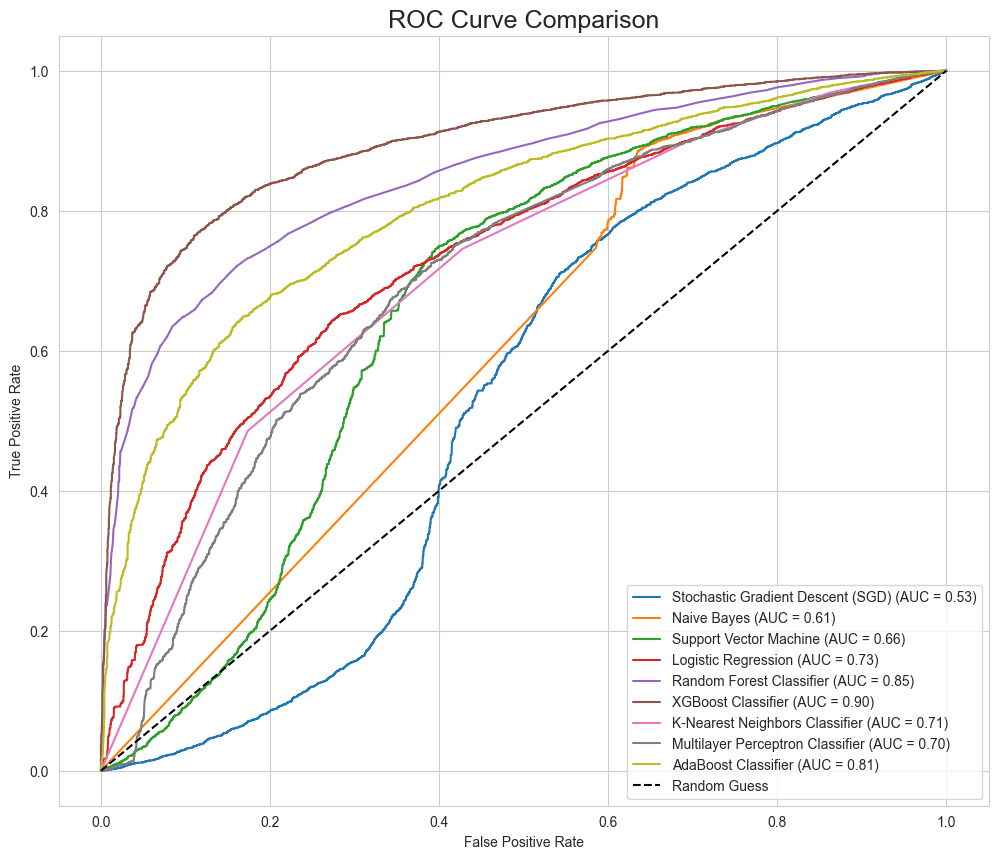

In [66]:
fig, ax = plt.subplots(figsize=(12, 10))

for name, model in models.items():
    pred = model.predict_proba(X_test)[:, 1] if name != "Stochastic Gradient Descent (SGD)" else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    ax.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

ax.plot([0, 1], [0, 1], 'k--', label='Random Guess')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve Comparison', fontsize=18)
ax.legend(loc="lower right")
plt.show()